\tableofcontents


\newpage

# Settings

In [22]:
import pyspark
sc = pyspark.SparkContext(appName="CLassification Task")

In [19]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [24]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql import SQLContext

\newpage

# Data Preparation

## Reading the data

In [25]:
sqlContext = SQLContext(sc)

# Building the DataFrame's schema
schema = StructType([ StructField("c"+str(i),StringType()) for i in range(24)])

# Importing the data from the csv file 
raw_data = sqlContext.read.csv(
            "/content/drive/MyDrive/exo1_train.csv",schema=schema)

# Droping the rows with missing values
raw_data_nn = raw_data.dropna()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


## Transforming the column values

In [28]:
def transform_data(data, Str_Ind):
  
  """
  transforms the alphabetical column values into numericals.

  :data: DataFrame containing the data that we want to change
  :Str_Ind: list of StringIndexer trained on the data
  :return: DataFrames with numerical values
  """ 

  #alphabetical culumn to numerical column
  for i, string_index in enumerate(Str_Ind):
    data = string_index.transform(data).drop("c"+str(i+1))

  #new column for vector features
  data = VectorAssembler(inputCols=["ft"+str(i) 
            for i in range(1,23)],outputCol="features").transform(data)

  #changing type of colum label and renaming the column
  data = data.withColumn("c23", data["c23"].cast(IntegerType()))
             .withColumnRenamed("c23", "label")

  return data

In [29]:
# Applying the transformation on the dataset

data = raw_data_nn

Str_Ind = [StringIndexer().
           setInputCol("c"+str(i)).
           setOutputCol("ft"+str(i)).fit(data) for i in range (1,23)]
           
data = transform_data(data, Str_Ind)

## Class Distribution in the dataset

In [30]:
tot_samples = data.count()
negative_samples = data.filter((data.label  == "0")).count()
positive_samples = data.filter((data.label  == "1")).count()

print("The total number of samples in our dataset is", tot_samples)

print("The number of samples for the class 0 is", negative_samples, 
      "which represents", round((negative_samples/tot_samples)*100, 2), 
      '% of the dataset')

print("The number of samples for the class 1 is", positive_samples, 
      "which represents", round((positive_samples/tot_samples)*100, 2), 
      '% of the dataset')

print("Therefore we have an almost equaly distributed dataset.")

The total number of samples in our dataset is 7250
The number of samples for the class 0 is 3512 which represents 48.44 % of the dataset
The number of samples for the class 1 is 3738 which represents 51.56 % of the dataset
Therefore we have an almost equaly distributed dataset.


## Split into training and validation

For the model selection, we have to divide our dataset into a training set and a validation set. We set the training ratio to be 80% of the dataset.

In [ ]:
train, val = data.randomSplit([0.8, 0.2], seed=12345)
val.show(5)

\newpage

# Classification Models

## Decision Tree

In [32]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from time import time
import seaborn as sn

### Finding optimal maximum depth 

In [37]:
def find_optimal_tree(maxDepth, train, val):

  """
  find the f02 score, precision and recall for a 
  defined max depth of a decision tree model 
  trained on a train data and validated on the 
  val data

  :maxDepth: integer, for the maximum depth of the DT
  :train: dataFrame, training set
  :val: dataFrame, validation set
  :return: evaluation metrics f02_score, precision, recall, computational time
  """ 


  #creating the DT model and fitting the data
  model = DecisionTreeClassifier(maxDepth=maxDepth,labelCol="label", 
                                 featuresCol="features").fit(train)

  #making predictions on the validation data
  t0=time()
  predictions = model.transform(val)
  t=time()-t0

  # Count True Positives
  TP = predictions.filter((predictions.label  == "1") & 
                          (predictions.prediction  == "1")).count()

  # Count False Positives
  FP = predictions.filter((predictions.label  == "0") & 
                          (predictions.prediction  == "1")).count()

  # Count True Negatives
  TN = predictions.filter((predictions.label  == "0") & 
                          (predictions.prediction  == "0")).count()

  # Count False Negatives
  FN = predictions.filter((predictions.label  == "1") & 
                          (predictions.prediction  == "0")).count()

  precision = TP / (TP+FP)
  recall = TP / (TP+FN)
  beta = 0.2
  f02_score = ((1+beta**2)*(precision*recall)) / ((beta**2)*precision+recall)

  #returning the accuracy score
  return f02_score*100, precision*100, recall*100, t

In [38]:
Depth, Scores_DT = [i for i in range(2, 11)], [[], [], [], []]
for maxDepth in Depth:
  f02_score, precision, recall, t = find_optimal_tree(maxDepth, train, val)
  Scores_DT[0].append(f02_score)
  Scores_DT[1].append(precision)
  Scores_DT[2].append(recall)
  Scores_DT[3].append(t)

#### Ploting evaluation metrics 

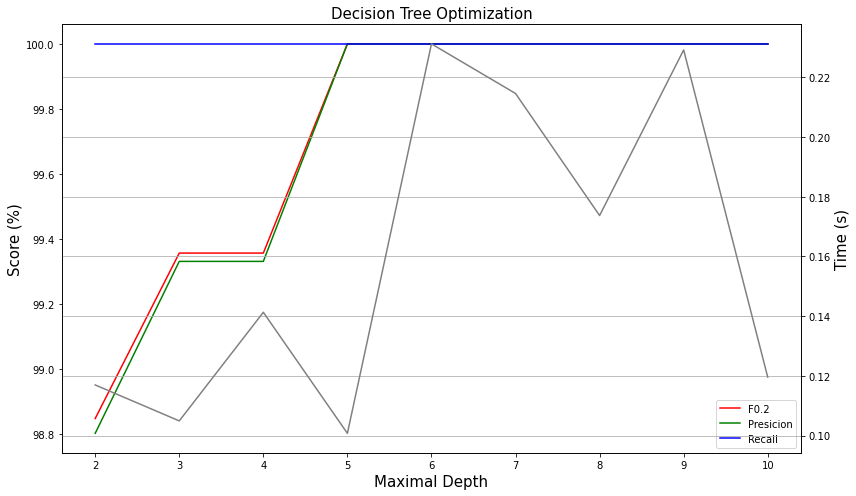

In [44]:
fig, ax1 = plt.subplots(figsize=(12,7))

ax1.set_xlabel('Maximal Depth', fontsize=15)
ax1.set_ylabel('Score (%)', fontsize=15)
ax1.plot(Depth, Scores_DT[0], label='F0.2', color='red')
ax1.plot(Depth, Scores_DT[1], label='Presicion', color='green')
ax1.plot(Depth, Scores_DT[2], label='Recall', color='blue')
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Time (s)', fontsize=15)
ax2.plot(Depth, Scores_DT[3], color='grey')


plt.grid()
plt.title('Decision Tree Optimization', fontsize=15)
fig.tight_layout()  
plt.show()

From the previous graph, we notice that the recall (in blue) is perfect for all the maximum depths.
On the other hand the precision grows rapidly from 98.8% to 100% by augmenting the max depth from 2 to 5 and stays at 100% after that.
The F02 score, since depends more on the precision than the recall, follows closely the precision by some extra percentages and gets to a value of 100% after a max depth of 5.
By computing the time needed for each max depth, we can decide between the values for which the F02 is 100%. Therefore we choose a max depth of 5 since it has the lowest computation time.

### Optimal model results

In [52]:
best_maxDepth = 5
print('The optimal maximum depth of the DT is', best_maxDepth)
#creating the DT model and fitting the data
model = DecisionTreeClassifier(maxDepth=best_maxDepth,labelCol="label", featuresCol="features").fit(train)

#making predictions on the validation data
predictions = model.transform(val)

# Count True Positives
TP = predictions.filter((predictions.label  == "1") & 
                        (predictions.prediction  == "1")).count()

# Count False Positives
FP = predictions.filter((predictions.label  == "0") & 
                        (predictions.prediction  == "1")).count()

# Count True Negatives
TN = predictions.filter((predictions.label  == "0") & 
                        (predictions.prediction  == "0")).count()

# Count False Negatives
FN = predictions.filter((predictions.label  == "1") & 
                        (predictions.prediction  == "0")).count()

precision = TP / (TP+FP)
recall = TP / (TP+FN)
beta = 0.2
f02_score = ((1+beta**2)*(precision*recall)) / ((beta**2)*precision+recall)

print('For this max depth we get a f02_score of', f02_score*100, 
      '% and a precision of', precision, '% and a recall of', 
      recall*100, '% on the validation dataset.')

The optimal maximum depth of the DT is 5
For this max depth we get a f02_score of 100.0 % and a precision of 1.0 % and a recall of 100.0 % on the validation dataset.


#### Confusion Matrix

We get the following confusion matrix:


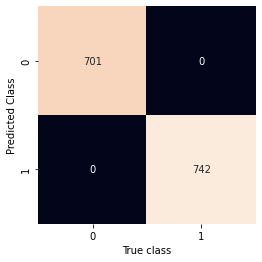

In [53]:
print('We get the following confusion matrix:')
cm = [[TN, FP], [FN, TP]]
sn.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True class')
plt.ylabel('Predicted Class')
plt.show()

#### Decision Tree visualizations

In [54]:
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b38d33d9b382, depth=5, numNodes=13, numClasses=2, numFeatures=22
  If (feature 17 in {1.0,2.0,3.0,6.0,7.0,8.0})
   Predict: 0.0
  Else (feature 17 not in {1.0,2.0,3.0,6.0,7.0,8.0})
   If (feature 2 in {4.0})
    Predict: 0.0
   Else (feature 2 not in {4.0})
    If (feature 7 in {8.0})
     Predict: 0.0
    Else (feature 7 not in {8.0})
     If (feature 7 in {3.0})
      If (feature 10 in {1.0})
       Predict: 0.0
      Else (feature 10 not in {1.0})
       Predict: 1.0
     Else (feature 7 not in {3.0})
      If (feature 20 in {3.0})
       Predict: 0.0
      Else (feature 20 not in {3.0})
       Predict: 1.0



In [56]:
from dtreeviz import trees
from dtreeviz.models.spark_decision_tree import ShadowSparkTree

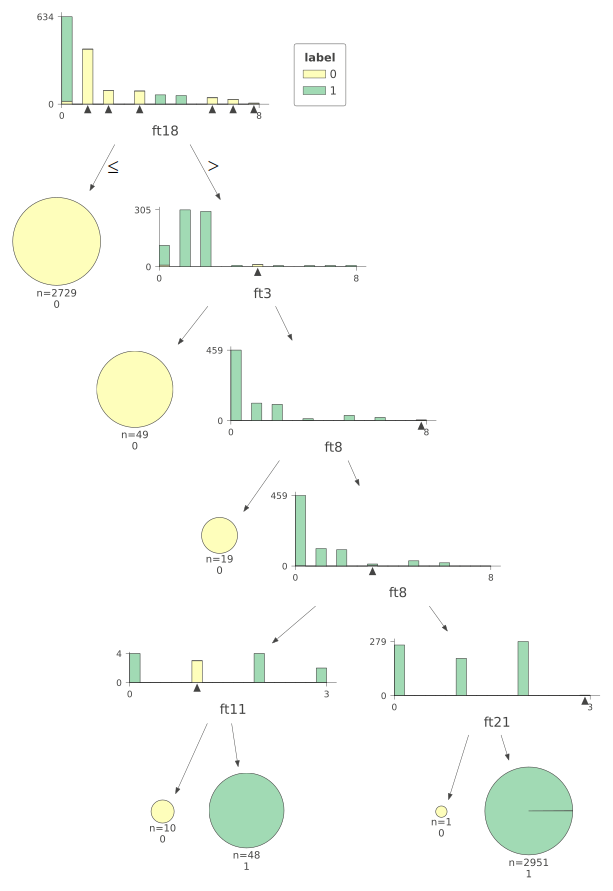

In [111]:
pred_pd = predictions.toPandas()
features, label = ['ft'+str(i) for i in range(1,23)], 'label'
spark_dtree = ShadowSparkTree(model, pred_pd[features], pred_pd[label], feature_names=features, target_name=label, class_names=[0, 1])
trees.dtreeviz(spark_dtree, fancy=True, fontname='DejaVu Sans', scale=1.5)

From the previous vizualization, we first note that the decisions are made based only on 5 features which are ft18, ft3, ft8, ft11 and ft21. 
This means that for whatever value we can get on the other dimensions it won't have an impact on the model's decision.
Furthermore, we notice that on the first leaf, the feature 18 has such an impact on the decision that just from that dimension we can classify almost half of the dataset as being part of the class 0.
Then, we also notice that a decision made relatively to the feature 8 happens twice and successively.

#### Ploting the ROC curve

In [ ]:
def get_curve(predictions,intermediate=1):
    points = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).collect()
    # points should be array containing on the first column 
    # the probability of being a 1 and in the second column
    # the label.
    points.sort()# sorts the points on the probability
    points.reverse()
    # First we compute the total number of True and False
    nbFalse = 0.
    nbTrue = 0.
    for (x,y) in points:
        nbFalse += 1-y
        nbTrue += y
    # We now use a sliding window algorithm to compute the ROC points
    # At the beggining we have seen 0 False, 0 True
    false_positive = 0
    true_positive = 0
    fpr=[0]
    tpr=[0]
    last_proba = -1 # we want one point for each possible threshold
    for (proba,label) in points:
        if label==1:
            true_positive += 1
        else:
            false_positive += 1
        if last_proba == proba: # remove last point if it was not taking into
            del tpr[-1]         # account all the points at a given threshold
            del fpr[-1]
            if intermediate != 1:
                del tpr[-1]
                del fpr[-1]
                
        last_proba = proba
        if intermediate == 0:
            tpr.append(tpr[-1])
        if intermediate == 2:
            fpr.append(fpr[-1])
        fpr.append(false_positive/nbFalse)
        tpr.append(true_positive/nbTrue)
        if intermediate == 0:
            fpr.append(fpr[-1])
        if intermediate == 2:
            tpr.append(tpr[-1])
        
    return (fpr,tpr)
        
def get_area(xs,ys):
    # supposes that the curve starts in (0,0) and finishes in (1,1)
    area = 0
    last_x = 0
    last_y = 0
    for i in range(len(xs)):
        area += (xs[i]-last_x)*(ys[i]+last_y)/2.
        last_x = xs[i]
        last_y = ys[i]
    return area

def plot(*spredictions,type=1):
    plt.title("ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    for predictions in spredictions:
        FPR,TPR = get_curve(predictions,type)
        area = get_area(FPR,TPR)
        print("Area Under ROC "+str(area))
        plt.plot(FPR,TPR)

Area Under ROC 1.0
Area Under ROC 1.0
Area Under ROC 1.0


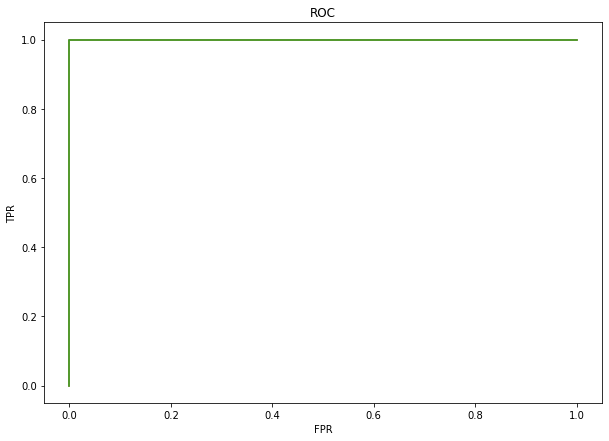

In [ ]:
plt.figure(figsize=(10,7))
for i in range(3):
    plot(predictions,type=i)

The previous ROC curve adds no information since the results were of 100% for all metrics.

### Finding optimal (maximum depth, maximum bins) with Cross Validation

Considering the previous results we could use Cross-validation to make better use of our data and gives us much more information about the performance of our algorithms to reveal the real performances and optimize the parameters on more general data.

In [51]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

decisionTree = DecisionTreeClassifier()

evaluator = BinaryClassificationEvaluator(
                  rawPredictionCol="rawPrediction",
                  labelCol="label",
                  metricName='areaUnderROC')

paramGrid = ParamGridBuilder()\
    .addGrid(decisionTree.maxBins, range(12,15)) \
    .addGrid(decisionTree.maxDepth, range(2,11)) \
    .build()

# 80% of the data will be used for training, 20% for validation.
cvs = CrossValidator(estimator=decisionTree,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

cvs_model = cvs.fit(train)
cvs_predictions = cvs_model.transform(val)

1.0

In [100]:
print("The best model has as parameters: ")
print("                                 - a depth of", cvs_model.bestModel.depth)
print("                                 - a nummber of Nodes of", cvs_model.bestModel.numNodes)

pred = [w.prediction for w in cvs_predictions.select('prediction').collect()]
label = [w.label for w in cvs_predictions.select('label').collect()]

# Count True Positives, False Positives, True Negatives and False Negatives
TP, FP, TN, FN = 0, 0, 0, 0


for p, l in zip(pred, label):
  if p==1 and l==1:
    TP+=1
  if p==1 and l==0:
    FP+=1
  if p==0 and l==0:
    TN+=1
  if p==0 and l==1:
    FN+=1

precision = TP / (TP+FP)
recall = TP / (TP+FN)
beta = 0.2
f02_score = ((1+beta**2)*(precision*recall)) / ((beta**2)*precision+recall)
print('\n')
print('For this max depth of', cvs_model.bestModel.depth, 'we get a F02_score of', 
      round(f02_score*100, 2), '% and a precision of', 
      precision*100, '% and a recall of', 
      recall*100, '% on the validation dataset.')

The best model has as parameters: 
                                 - a depth of 8
                                 - a nummber of Nodes of 19


For this max depth of 8 we get a F02_score of 100.0 % and a precision of 100.0 % and a recall of 100.0 % on the validation dataset.


The results on the Cross Validation helped optimize the parameters on a more global way since we have obtained an optimal max depth different to what we had before.

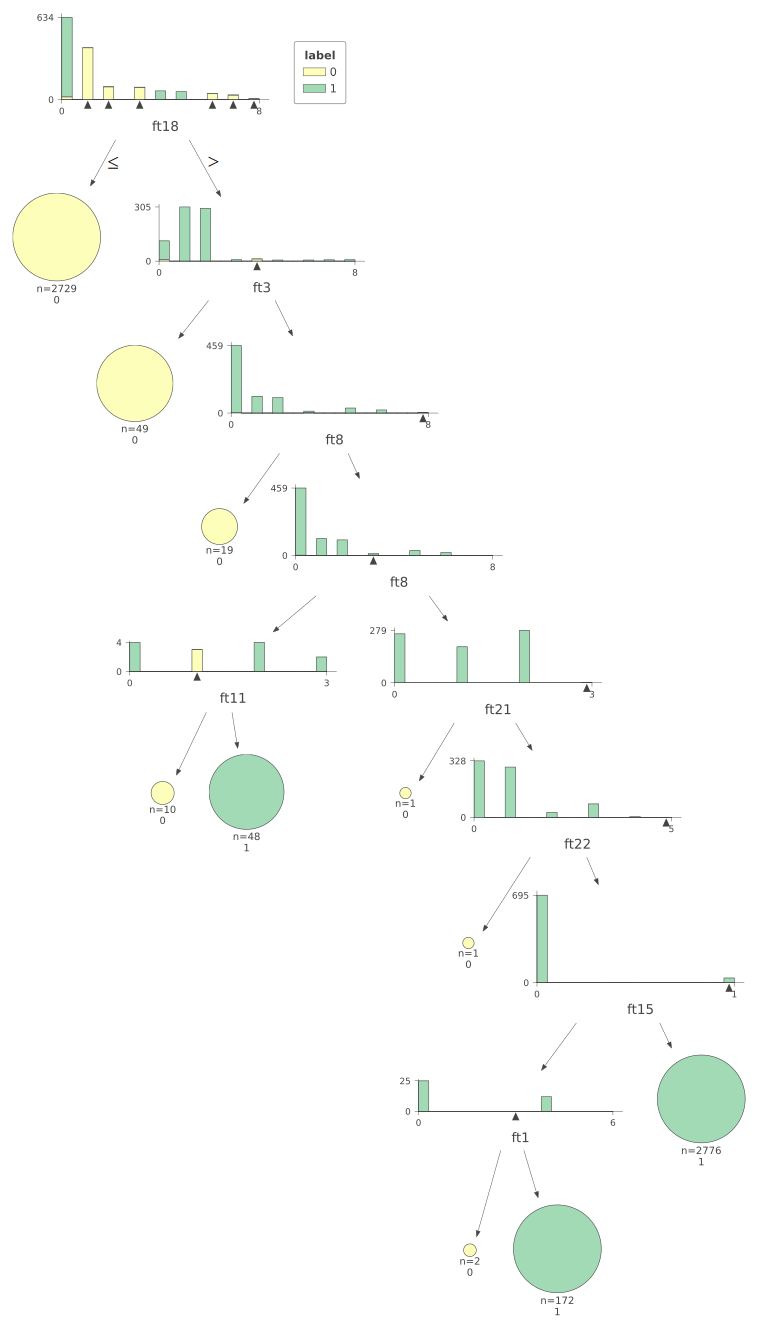

In [112]:
pred_pd = cvs_predictions.toPandas()

features, label = ['ft'+str(i) for i in range(1,23)], 'label'

spark_dtree = ShadowSparkTree(cvs_model.bestModel, 
                              pred_pd[features],
                              pred_pd[label], 
                              feature_names=features, 
                              target_name=label, 
                              class_names=[0, 1])

trees.dtreeviz(spark_dtree, fancy=True, fontname='DejaVu Sans', scale=1.5)

This new decision tree is very similar to the previous one particularly on the first depths. However we notice the apearance of new decisional features such as ft15, ft22 and ft1.

# Testing

After training the data on the Decision Tree model, we were able to get perfect classification scores, therefore we've limited the model selection to only one model

## Reading test dataset

In [107]:
sqlContext = SQLContext(sc)
#indexer needed so that labels are 0 and 1


schema = StructType([ StructField("c"+str(i),StringType()) for i in range(24)])
#importing the test data
raw_data_test = sqlContext.read.csv(
                    "/content/drive/MyDrive/exo1_predict.csv",schema=schema)

#projecting the data by the string indexers
data_test = transform_data(raw_data_test, Str_Ind)

#making the predictions on the test data 
test_predictions = cvs_model.transform(data_test)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


## Saving the results in exo1.csv

In [114]:
# collecting the predictions and indexes
pred = [w.prediction for w in test_predictions.select('prediction').collect()]
ind = [w.c0 for w in test_predictions.select('c0').collect()]

with open('exo1.csv','wb') as file:
  for p, i in zip(pred, ind):
    file.write((str(i)+','+str(p)+'\n').encode())

# Visualization the paths taken by two samples in the Decision Tree

Here we present the path taken by 2 samples taken from the test dataset and which follow different paths in the decision tree

In [108]:
pred_pd = predictions.toPandas()

pred_pd_test = test_predictions.toPandas()

features, label = ['ft'+str(i) for i in range(1,23)], 'label'

spark_dtree = ShadowSparkTree(cvs_model.bestModel, 
                              pred_pd[features], 
                              pred_pd[label], 
                              feature_names=features, 
                              target_name=label, 
                              class_names=[0, 1])

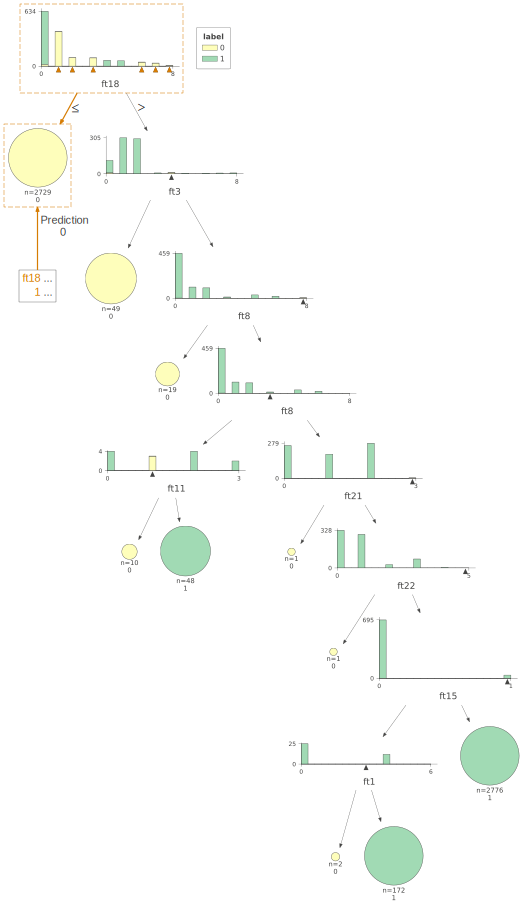

In [118]:
X = [int(x) for x in pred_pd_test.features[15]]
trees.dtreeviz(spark_dtree, fancy=True, fontname='DejaVu Sans', scale=1, X=X)

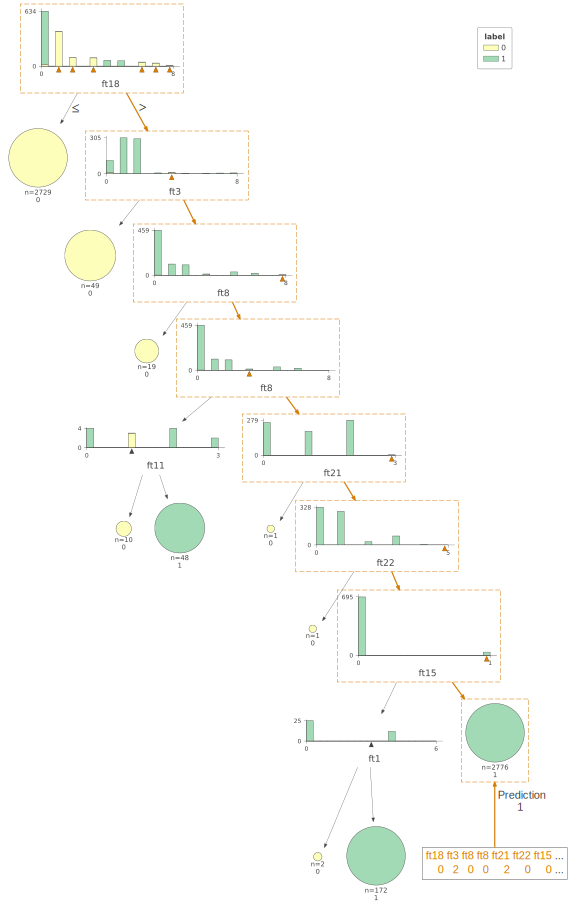

In [117]:
X = [int(x) for x in pred_pd_test.features[255]]
trees.dtreeviz(spark_dtree, fancy=True, fontname='DejaVu Sans', scale=1, X=X)